In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sn
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor
import timeit

In [2]:
# set seed and read data
random.seed(7406)
dataset_hour = pd.read_csv("hour.csv")
dataset_day = pd.read_csv("day.csv")
display(dataset_hour)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


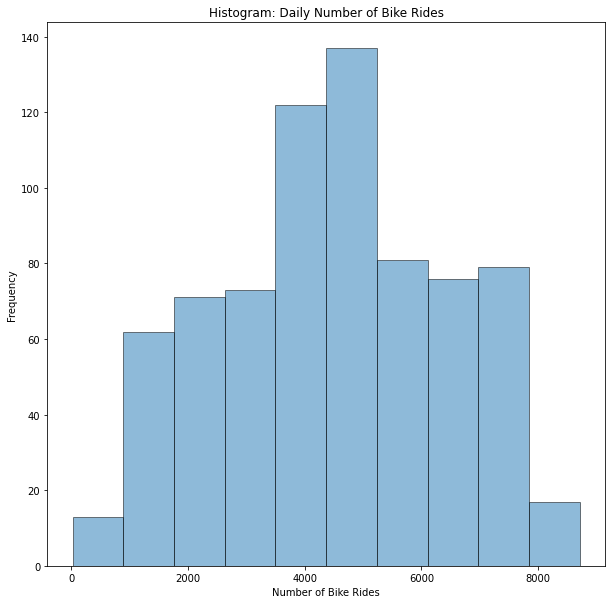

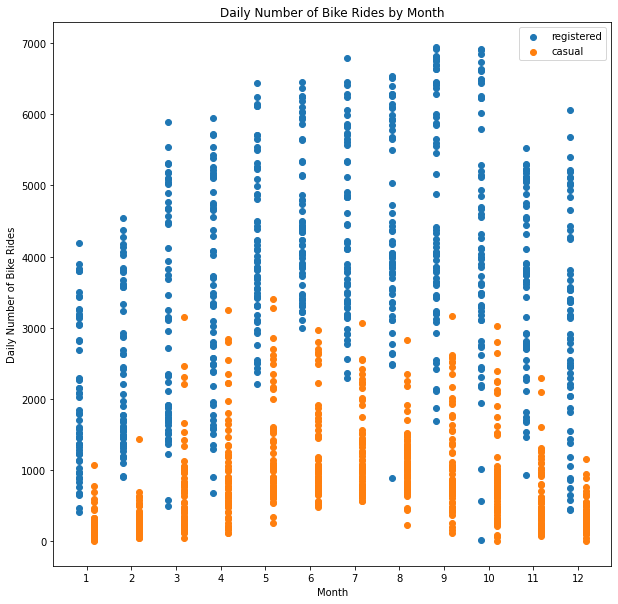

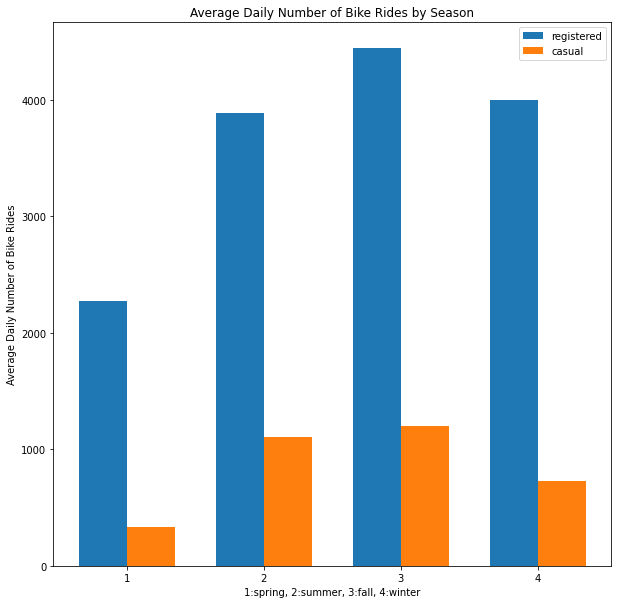

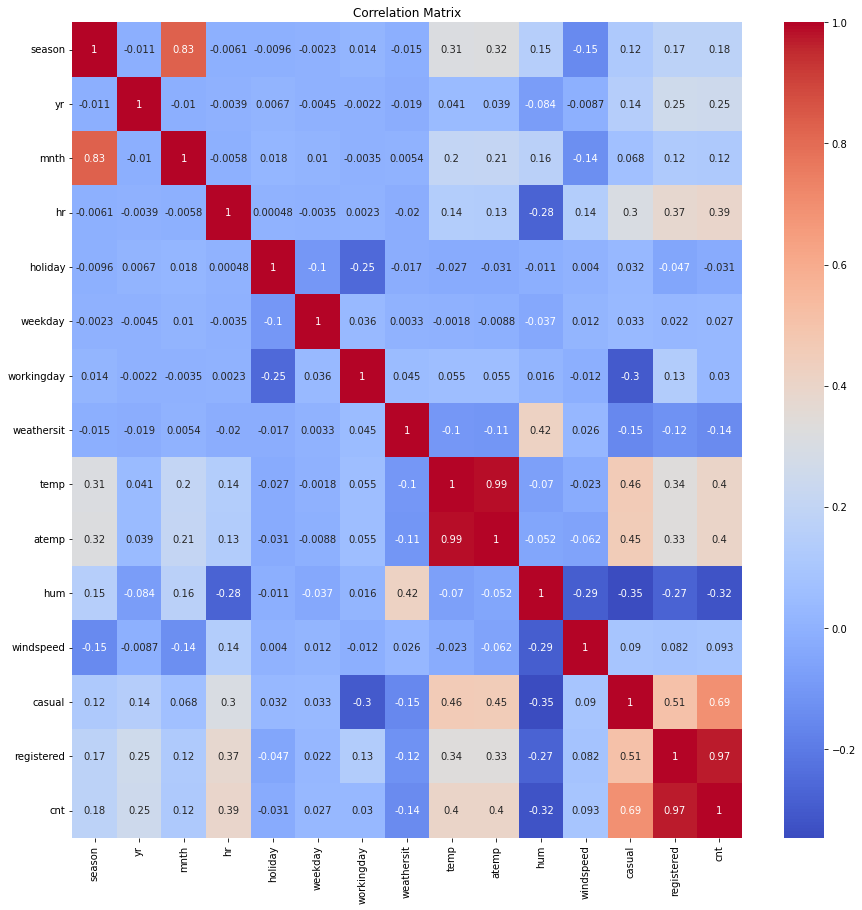

In [3]:
# Exploratory data analysis

# Histogram of response variable
response_day = dataset_day['cnt'].values
plt.figure(figsize=(10, 10))
plt.hist(response_day, alpha=0.5, histtype='bar', ec='black')
plt.title("Histogram: Daily Number of Bike Rides")
plt.xlabel('Number of Bike Rides')
plt.ylabel('Frequency')
plt.show()

# Scatter: Casual and registered
plt.figure(figsize=(10, 10))
plt.scatter(dataset_day['mnth'].values - 0.35/2, dataset_day['registered'].values, label = 'registered')
plt.scatter(dataset_day['mnth'].values + 0.35/2, dataset_day['casual'].values, label = 'casual')
plt.locator_params(axis = "x", nbins = 24)
plt.legend()
plt.title("Daily Number of Bike Rides by Month")
plt.xlabel('Month')
plt.ylabel('Daily Number of Bike Rides')
plt.show()

# Average Daily Number of Bike Rides by Season
season = dataset_day[['season','casual', 'registered']].groupby('season').agg('mean')
plt.figure(figsize=(10, 10))
plt.bar(season.index - 0.35/2, season['registered'].values, 0.35, label = 'registered')
plt.bar(season.index + 0.35/2, season['casual'].values, 0.35, label = 'casual')
plt.locator_params(axis = "x", nbins = 8)
plt.title("Average Daily Number of Bike Rides by Season")
plt.xlabel('1:spring, 2:summer, 3:fall, 4:winter')
plt.ylabel('Average Daily Number of Bike Rides')
plt.legend()
plt.show()

# Correlation matrix of factors - Hourly Bike Rides
plt.figure(figsize=(15, 15))
corr = dataset_hour.drop(columns=['instant', 'dteday']).corr()
sn.heatmap(corr, annot = True, cmap= 'coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [4]:
# Exploratory data analysis

In [5]:
# Variable selection
dataset = dataset_hour.drop(columns=['instant', 'dteday', 'registered', 'casual'])
y = dataset[['cnt']]
x = dataset.drop(columns=['cnt'])

# Ordinary Least Squares - Manual Backward selection based on p-value (months and workingday were eliminated)
model1_ols = sm.OLS(y,x).fit()

x2_ols = x.drop(columns=['mnth'])
model2_ols = sm.OLS(y,x2_ols).fit()

x3_ols = x2_ols.drop(columns=['workingday'])
model3_ols = sm.OLS(y,x3_ols).fit()
print(model3_ols.summary())

# Recursive feature elimination RFE with Regression - Backward (months and weekday were eliminated)
model1_rfe = RFE(LinearRegression(), n_features_to_select=10, step=1)
model1_rfe.fit(x, y)
print("RFE results", x.columns[model1_rfe.get_support()])

# Sequential Feature selection - based on CV score (months and windpeed were eliminated)
model1_sf = SequentialFeatureSelector(estimator = LinearRegression(), n_features_to_select = 10, cv = 10, direction = 'forward')
model1_sf.fit(x,y)
print("Sequential Feature Results - Forward", x.columns[model1_sf.get_support()])

# Sequential Feature selection - based on CV score (months and temp were eliminated)
model2_sf = SequentialFeatureSelector(estimator = LinearRegression(), n_features_to_select = 10, cv = 5, direction = 'backward')
model2_sf.fit(x,y)
print("Sequential Feature Results - Backward", x.columns[model2_sf.get_support()])


                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.708
Model:                            OLS   Adj. R-squared (uncentered):              0.707
Method:                 Least Squares   F-statistic:                              4201.
Date:                Tue, 16 Nov 2021   Prob (F-statistic):                        0.00
Time:                        21:58:05   Log-Likelihood:                     -1.1077e+05
No. Observations:               17379   AIC:                                  2.216e+05
Df Residuals:                   17369   BIC:                                  2.216e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

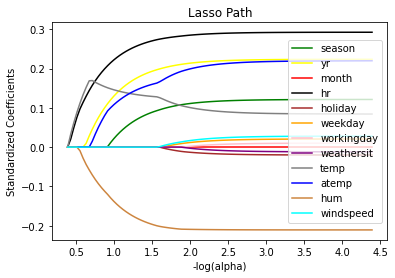

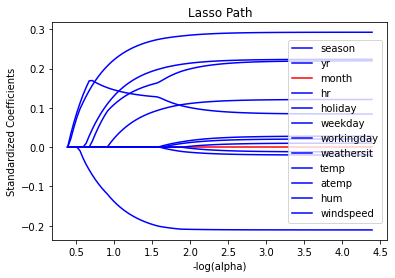

In [6]:
# LASSO Variable Selection (month was eliminated)
dataset_lasso = StandardScaler().fit_transform(dataset)
y_lasso = dataset_lasso[:,-1]
x_lasso = dataset_lasso[:,:-1]

eps = 1e-4
alphas_lasso, coefs_lasso, _ = lasso_path(x_lasso,y_lasso, eps = eps)
neg_log = -np.log10(alphas_lasso)
colors = ['green','yellow','red','black','brown','orange','pink','purple','gray','blue','peru','cyan']
plt.figure()
for coef,c in zip(coefs_lasso, colors):
    l = plt.plot(neg_log, coef, c)
plt.xlabel('-log(alpha)')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso Path')
plt.legend(['season', 'yr', 'month', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp',
       'atemp', 'hum', 'windspeed'])
plt.show()

colors = ['blue','blue','red','blue','blue','blue','blue','blue','blue','blue','blue','blue']
plt.figure()
for coef,c in zip(coefs_lasso, colors):
    l = plt.plot(neg_log, coef, c)
plt.xlabel('-log(alpha)')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso Path')
plt.legend(['season', 'yr', 'month', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp',
       'atemp', 'hum', 'windspeed'])
plt.show()

In [7]:
# Normalizing, training and testing sets
dataset_final = dataset.drop(columns=['mnth']).to_numpy()
dataset_y = dataset_final[:,-1]
dataset_x = dataset_final[:,:-1]
x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size = 0.2, random_state = 7406, shuffle = True)

Time to run:  2.5464300919999996
The best regularizer parameter is:  {'alpha': 0.0033999999999999976}
The mean squared training error of the LASSO Model is:  19963.211001752516
The mean squared testing error of the LASSO Model is:  20693.293949655843
The R-Squared of the Lasso Model is:  0.38731987474736407


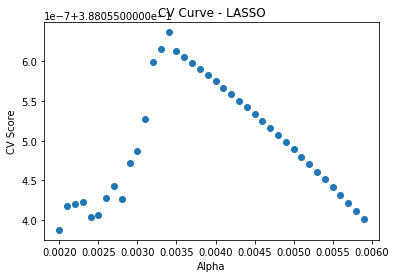

In [8]:
# LASSO
alpha = np.arange(0.002,0.006,0.0001)
lasso_parameters = {'alpha': alpha} 
lasso_cv = GridSearchCV(Lasso(random_state = 7406), lasso_parameters, n_jobs = -1)

a = timeit.default_timer()
lasso_cv.fit(x_train,y_train)
print("Time to run: ",timeit.default_timer() - a)

lasso_predicted_train = lasso_cv.predict(x_train)
lasso_MSE_train = mean_squared_error(y_train, lasso_predicted_train)
lasso_predicted_test = lasso_cv.predict(x_test)
lasso_MSE_test = mean_squared_error(y_test, lasso_predicted_test)

print("The best regularizer parameter is: ", lasso_cv.best_params_)
print("The mean squared training error of the LASSO Model is: ", lasso_MSE_train)
print("The mean squared testing error of the LASSO Model is: ", lasso_MSE_test)
print("The R-Squared of the Lasso Model is: ", r2_score(y_test, lasso_predicted_test))

plt.figure()
plt.scatter(alpha, lasso_cv.cv_results_['mean_test_score'])
plt.title("CV Curve - LASSO")
plt.xlabel('Alpha')
plt.ylabel('CV Score')
plt.show()

Time to run:  28.688475987000004
The best regularizer parameter is:  {'ccp_alpha': 3.4000000000000004}
The mean squared training error of the Decision Tree Model is:  1826.5289468066308
The mean squared testing error of the Decision Tree Model is:  3262.8783860899935
The R-Squared of the Decision Tree Model is:  0.9033937881935425


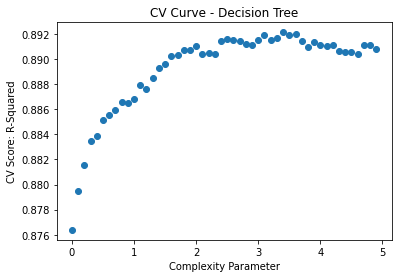

In [9]:
# Decision Tree
n_estimators = np.arange(0,5,0.1)
tree_parameters = {'ccp_alpha': n_estimators} 
tree_cv = GridSearchCV(DecisionTreeRegressor(random_state = 7406), tree_parameters, n_jobs = -1)

a = timeit.default_timer()
tree_cv.fit(x_train,y_train)
print("Time to run: ",timeit.default_timer() - a)

tree_predicted_train = tree_cv.predict(x_train)
tree_MSE_train = mean_squared_error(y_train, tree_predicted_train)
tree_predicted_test = tree_cv.predict(x_test)
tree_MSE_test = mean_squared_error(y_test, tree_predicted_test)

print("The best regularizer parameter is: ", tree_cv.best_params_)
print("The mean squared training error of the Decision Tree Model is: ", tree_MSE_train)
print("The mean squared testing error of the Decision Tree Model is: ", tree_MSE_test)
print("The R-Squared of the Decision Tree Model is: ", r2_score(y_test, tree_predicted_test))

plt.figure()
plt.scatter(n_estimators, tree_cv.cv_results_['mean_test_score'])
plt.title("CV Curve - Decision Tree")
plt.xlabel('Complexity Parameter')
plt.ylabel('CV Score: R-Squared')
plt.show()

Time to run:  76.19279588199998
The best regularizer parameter is:  {'n_estimators': 160}
The mean squared training error of the Random Forest Model is:  288.22630785210947
The mean squared testing error of the Random Forest Model is:  1774.5689967672056
The R-Squared of the Random Forest Model is:  0.9474591547457887


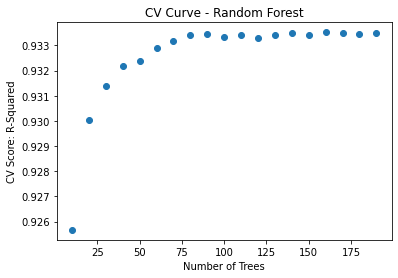

In [10]:
# Random Forest
n_estimators = np.arange(10,200,10)
forest_parameters = {'n_estimators': n_estimators} 
forest_cv = GridSearchCV(RandomForestRegressor(random_state = 7406), forest_parameters, n_jobs = -1)

a = timeit.default_timer()
forest_cv.fit(x_train,y_train)
print("Time to run: ",timeit.default_timer() - a)

forest_predicted_train = forest_cv.predict(x_train)
forest_MSE_train = mean_squared_error(y_train, forest_predicted_train)
forest_predicted_test = forest_cv.predict(x_test)
forest_MSE_test = mean_squared_error(y_test, forest_predicted_test)

print("The best regularizer parameter is: ", forest_cv.best_params_)
print("The mean squared training error of the Random Forest Model is: ", forest_MSE_train)
print("The mean squared testing error of the Random Forest Model is: ", forest_MSE_test)
print("The R-Squared of the Random Forest Model is: ", r2_score(y_test, forest_predicted_test))

plt.figure()
plt.scatter(n_estimators, forest_cv.cv_results_['mean_test_score'])
plt.title("CV Curve - Random Forest")
plt.xlabel('Number of Trees')
plt.ylabel('CV Score: R-Squared')
plt.show()



Time to run:  24.598606195000002
The best regularizer parameter is:  {'learning_rate': 1.1}
The mean squared training error of the Ada Boost Model is:  12041.624483256419
The mean squared testing error of the Ada Boost Model is:  12112.58709306171
The R-Squared of the Ada Boost Model is:  0.6413745730686857


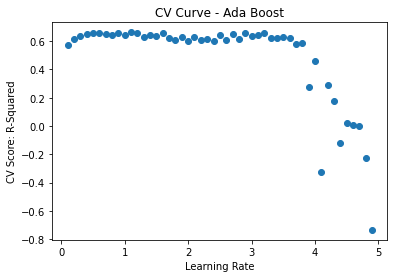

In [11]:
# AdaBoost Regressor with Regression Tree

n_estimators = np.arange(0.1,5,0.1)
ada_parameters = {'learning_rate': n_estimators} 
ada_cv = GridSearchCV(AdaBoostRegressor(random_state = 7406), ada_parameters, n_jobs = -1)

a = timeit.default_timer()
ada_cv.fit(x_train,y_train)
print("Time to run: ",timeit.default_timer() - a)

ada_predicted_train = ada_cv.predict(x_train)
ada_MSE_train = mean_squared_error(y_train, ada_predicted_train)
ada_predicted_test = ada_cv.predict(x_test)
ada_MSE_test = mean_squared_error(y_test, ada_predicted_test)

print("The best regularizer parameter is: ", ada_cv.best_params_)
print("The mean squared training error of the Ada Boost Model is: ", ada_MSE_train)
print("The mean squared testing error of the Ada Boost Model is: ", ada_MSE_test)
print("The R-Squared of the Ada Boost Model is: ", r2_score(y_test, ada_predicted_test))

plt.figure()
plt.scatter(n_estimators, ada_cv.cv_results_['mean_test_score'])
plt.title("CV Curve - Ada Boost")
plt.xlabel('Learning Rate')
plt.ylabel('CV Score: R-Squared')
plt.show()

Time to run:  38.86540476900001
The best regularizer parameter is:  {'n_estimators': 90}
The mean squared training error of the Bagging Regressor Model is:  294.09039934749217
The mean squared testing error of the Bagging Regressor Model is:  1797.510765686271
The R-Squared of the Bagging Regressor Model is:  0.9467799025257677


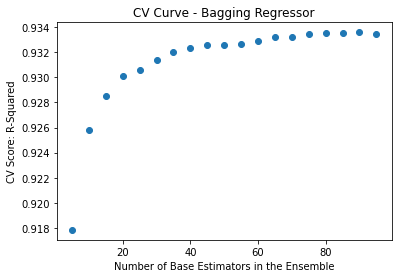

In [12]:
# Bagging Regressor

n_estimators = np.arange(5,100,5)
bagging_parameters = {'n_estimators': n_estimators} 
bagging_cv = GridSearchCV(BaggingRegressor(random_state = 7406), bagging_parameters, n_jobs = -1)

a = timeit.default_timer()
bagging_cv.fit(x_train,y_train)
print("Time to run: ",timeit.default_timer() - a)

bagging_predicted_train = bagging_cv.predict(x_train)
bagging_MSE_train = mean_squared_error(y_train, bagging_predicted_train)
bagging_predicted_test = bagging_cv.predict(x_test)
bagging_MSE_test = mean_squared_error(y_test, bagging_predicted_test)

print("The best regularizer parameter is: ", bagging_cv.best_params_)
print("The mean squared training error of the Bagging Regressor Model is: ", bagging_MSE_train)
print("The mean squared testing error of the Bagging Regressor Model is: ", bagging_MSE_test)
print("The R-Squared of the Bagging Regressor Model is: ", r2_score(y_test, bagging_predicted_test))

plt.figure()
plt.scatter(n_estimators, bagging_cv.cv_results_['mean_test_score'])
plt.title("CV Curve - Bagging Regressor")
plt.xlabel('Number of Base Estimators in the Ensemble')
plt.ylabel('CV Score: R-Squared')
plt.show()

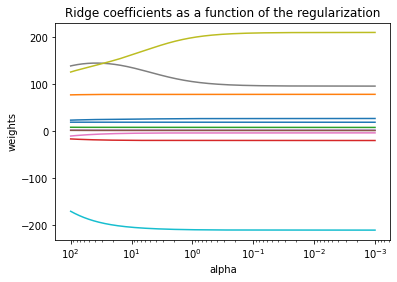

Time to run:  0.0018068439999865404
The best regularizer parameter is:  <bound method BaseEstimator.get_params of Ridge(alpha=1.7429999999999999)>
The mean squared training error of the Ridge Model is:  19963.71526463728
The mean squared testing error of the Ridge Model is:  20691.322784231408
The R-Squared of the Ridge Model is:  0.38737823635388613


In [13]:
# Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

seq = np.arange(0.001,100,0.001)

mod_ridge = RidgeCV(alphas=seq).fit(x_train, y_train)

mod_ridge.score(x_train, y_train)

ridge_alpha = mod_ridge.alpha_

coefs = []
for a in seq:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(x_train, y_train)
    coefs.append(ridge.coef_)


ax = plt.gca()

ax.plot(seq, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

a = timeit.default_timer()
mod_ridge_final = Ridge(alpha=ridge_alpha)
mod_ridge_final = mod_ridge_final.fit(x_train,y_train)
print("Time to run: ",timeit.default_timer() - a)

ridge_score = mod_ridge_final.score(x_test,y_test) # Metrics: R2
ridge_predicted_train = mod_ridge_final.predict(x_train)
ridge_MSE_train = mean_squared_error(y_train, ridge_predicted_train)
ridge_predicted_test = mod_ridge_final.predict(x_test)
ridge_MSE_test = mean_squared_error(y_test, ridge_predicted_test)

print("The best regularizer parameter is: ", mod_ridge_final.get_params)
print("The mean squared training error of the Ridge Model is: ", ridge_MSE_train)
print("The mean squared testing error of the Ridge Model is: ", ridge_MSE_test)
print("The R-Squared of the Ridge Model is: ", r2_score(y_test, ridge_predicted_test))



Time to run:  0.7147243529999514
The best regularizer parameter is:  {'alpha': 0.002}
The mean squared training error of the Elastic Net Model is:  19969.37239277547
The mean squared testing error of the Elastic Net Model is:  20691.76935226375
The R-Squared of the Elastic Net Model is:  0.3873650145169637


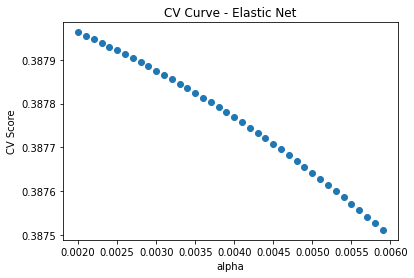

In [14]:
#Elastic net
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import enet_path
EN_model = ElasticNet()

alpha = np.arange(0.002,0.006,0.0001)
EN_parameters = {'alpha': alpha}
EN_cv = GridSearchCV(ElasticNet(random_state = 7406), EN_parameters, n_jobs = -1)

a = timeit.default_timer()
EN_cv = EN_cv.fit(x_train,y_train)
print("Time to run: ",timeit.default_timer() - a)

EN_predicted_train = EN_cv.predict(x_train)
EN_MSE_train = mean_squared_error(y_train, EN_predicted_train)
EN_predicted_test = EN_cv.predict(x_test)
EN_MSE_test = mean_squared_error(y_test, EN_predicted_test)

print("The best regularizer parameter is: ", EN_cv.best_params_)
print("The mean squared training error of the Elastic Net Model is: ", EN_MSE_train)
print("The mean squared testing error of the Elastic Net Model is: ", EN_MSE_test)
print("The R-Squared of the Elastic Net Model is: ", r2_score(y_test, EN_predicted_test))

plt.figure()
plt.scatter(alpha, EN_cv.cv_results_['mean_test_score'])
plt.title("CV Curve - Elastic Net")
plt.xlabel('alpha')
plt.ylabel('CV Score')
plt.show()


In [15]:
a = timeit.default_timer()
model1_ols = sm.OLS(y_train,x_train).fit()
print("Time to run: ",timeit.default_timer() - a)

ols_predicted_train = model1_ols.predict(x_train)
ols_MSE_train = mean_squared_error(y_train, ols_predicted_train)
ols_predicted_test = model1_ols.predict(x_test)
ols_MSE_test = mean_squared_error(y_test, ols_predicted_test)

print("The mean squared training error of the OLS Model is: ", ols_MSE_train)
print("The mean squared testing error of the OLS Model is: ", ols_MSE_test)
print("The R-Squared of the OLS Model is: ", model1_ols.rsquared)

Time to run:  0.01027241200000617
The mean squared training error of the OLS Model is:  19978.39722899816
The mean squared testing error of the OLS Model is:  20709.979480904636
The R-Squared of the OLS Model is:  0.7081212315310645


In [16]:
model1_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.708
Model:                            OLS   Adj. R-squared (uncentered):              0.708
Method:                 Least Squares   F-statistic:                              3064.
Date:                Tue, 16 Nov 2021   Prob (F-statistic):                        0.00
Time:                        22:02:55   Log-Likelihood:                         -88564.
No. Observations:               13903   AIC:                                  1.772e+05
Df Residuals:                   13892   BIC:                                  1.772e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            18.4436      1.150     16.033      0.000      16.189      20.698
x2            77.8177      2.360     32.980      0.000      73.193      82.443
x3             7.4428      0.174     42.744      0.000       7.102       7.784
x4           -20.3810      7.320     -2.784      0.005     -34.730      -6.032
x5             1.5371      0.580      2.650      0.008       0.400       2.674
x6             0.7717      2.605      0.296      0.767      -4.335       5.879
x7            -4.1416      2.109     -1.963      0.050      -8.277      -0.007
x8            95.2953     39.875      2.390      0.017      17.134     173.456
x9           209.4516     44.193      4.739      0.000     122.828     296.076
x10         -210.9538      6.375    -33.090      0.000    -223.450    -198.458
x11           26.4394      9.572      2.762      0.006       7.678      45.201
==============================================================================
Omnibus:                     2851.162   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5741.800
Skew:                           1.228   Prob(JB):                         0.00
Kurtosis:                       4.970   Cond. No.                         694.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


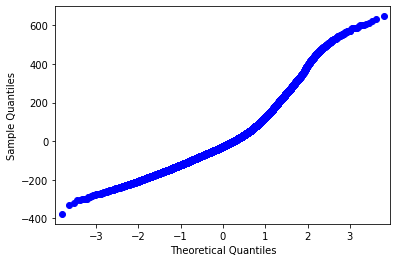

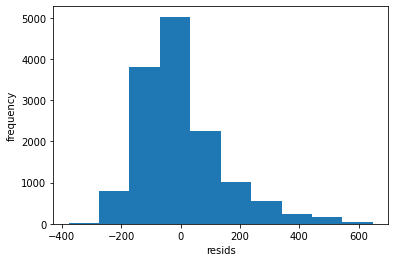

In [17]:
# Residual Analysis
from statsmodels.stats.outliers_influence import OLSInfluence
import pylab as py
res = OLSInfluence(model1_ols).resid
fits = model1_ols.fittedvalues
sm.qqplot(res)
py.show()
plt.hist(res)

plt.xlabel('resids')
plt.ylabel('frequency')
plt.show()



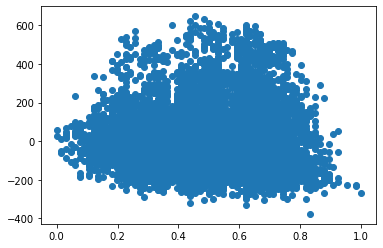

In [18]:
#atemp
plt.scatter(x_train[:,8],res)

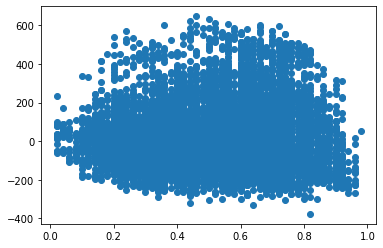

In [19]:
#temp
plt.scatter(x_train[:,7],res)

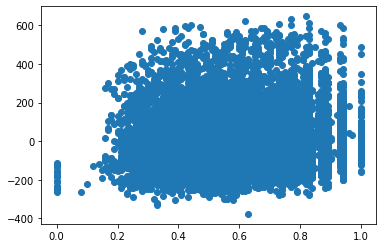

In [20]:
#hum
plt.scatter(x_train[:,9],res)

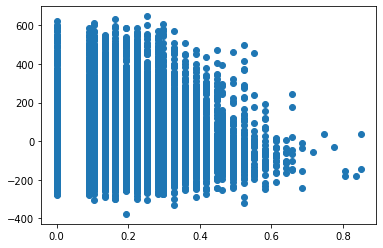

In [21]:
#windspeed
plt.scatter(x_train[:,10],res)

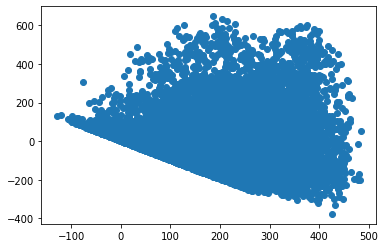

In [22]:
#fitted values vs residuals
plt.scatter(fits,res)

In [23]:
from statsmodels.genmod.families import Poisson
from scipy.stats import chi2

a = timeit.default_timer()
model2_psn = sm.GLM(y_train,x_train, family=Poisson()).fit()
print("Time to run: ",timeit.default_timer() - a)

model2_psn.summary2()

Time to run:  0.036285953999993126


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
=================================================================
Model:              GLM              AIC:            2063846.7540
Link Function:      log              BIC:            1842538.5230
Dependent Variable: y                Log-Likelihood: -1.0319e+06 
Date:               2021-11-16 22:02 LL-Null:        -1.1954e+06 
No. Observations:   13903            Deviance:       1.9751e+06  
Df Model:           10               Pearson chi2:   2.86e+06    
Df Residuals:       13892            Scale:          1.0000      
Method:             IRLS                                         
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1        0.2844     0.0007   418.9230   0.0000    0.2831    0.2858
x2        0.6652     0.0013   504.9010   0.0000    0.6626    0.6677
x3        0.0725     0.0001   714.4384   0.0000    0.0723    0.0727
x4        0.2156     0.0041    53.0568   0.0000    0.2076    0.2235
x5        0.0764     0.0003   231.6230   0.0000    0.0758    0.0771
x6        0.2705     0.0015   183.6467   0.0000    0.2676    0.2734
x7        0.0663     0.0011    59.3743   0.0000    0.0641    0.0684
x8       -1.7883     0.0233   -76.7951   0.0000   -1.8339   -1.7426
x9        5.2418     0.0259   202.7504   0.0000    5.1912    5.2925
x10       0.5396     0.0036   147.8442   0.0000    0.5324    0.5467
x11       1.9657     0.0051   388.1851   0.0000    1.9557    1.9756
=================================================================

"""

In [24]:
psn_predicted_train = model2_psn.predict(x_train)
psn_MSE_train = mean_squared_error(y_train, psn_predicted_train)
psn_predicted_test = model2_psn.predict(x_test)
psn_MSE_test = mean_squared_error(y_test, psn_predicted_test)
psn_RSS = np.sum(np.square(psn_predicted_test - y_test))
y_test_mean = np.average(y_test)
TSS = np.sum(np.square(y_test-y_test_mean))
print("The mean squared training error of the Poisson Model is: ", psn_MSE_train)
print("The mean squared testing error of the Poisson Model is: ", psn_MSE_test)
##manually divide SSE and SSR to get R2
print(r2_score(y_test, psn_predicted_test))
print((1-(psn_RSS/TSS)))
print(len(y_test))
print(len(psn_predicted_test))

The mean squared training error of the Poisson Model is:  34526.10436301757
The mean squared testing error of the Poisson Model is:  33936.87480500303
-0.004791637174713426
-0.004791637174713426
3476
3476


/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


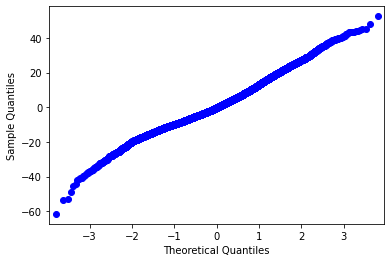

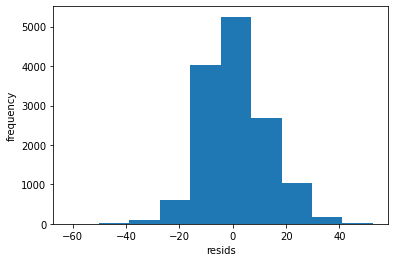

In [25]:
res2 = model2_psn.resid_deviance
fits2 = model2_psn.fittedvalues
sm.qqplot(res2)
py.show()
plt.hist(res2)
plt.xlabel('resids')
plt.ylabel('frequency')
plt.show()

In [26]:
print(1-chi2.cdf(model2_psn.deviance, model2_psn.df_resid))

#Model does fit the data

0.0


In [27]:
print(x_train[0])

[ 4.      0.     19.      0.      5.      1.      2.      0.32    0.303
  0.45    0.2239]


In [28]:
# Neural Networks

neural_parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
neural_cv = GridSearchCV(MLPRegressor(random_state = 7406), neural_parameters, n_jobs = -1, cv = 5)

a = timeit.default_timer()
neural_cv.fit(x_train,y_train)
print("Time to run: ",timeit.default_timer() - a)

neural_predicted_train = neural_cv.predict(x_train)
neural_MSE_train = mean_squared_error(y_train, neural_predicted_train)
neural_predicted_test = neural_cv.predict(x_test)
neural_MSE_test = mean_squared_error(y_test, neural_predicted_test)

print("The best regularizer parameter is: ", neural_cv.best_params_)
print("The mean squared training error of the Neural Networks Model is: ", neural_MSE_train)
print("The mean squared testing error of the Neural Networks Model is: ",neural_MSE_test)
print("The R-Squared of the Neural Networks Model is: ", r2_score(y_test, neural_predicted_test))

/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_ne

/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_ne

/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_ne

/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_ne

/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [-4.23820009e-04  8.35253215e-01 -1.31357188e-04  8.35253215e-01
 -7.90509223e-04  8.38340000e-01 -1.31619801e-04  8.38340000e-01
  2.51145900e-01  6.68200771e-01  2.93396519e-01  6.68200771e-01
 -4.23868860e-04  8.33752829e-01 -1.31356097e-04  8.33752829e-01
 -7.90686061e-04  8.37357778e-01 -1.31617750e-04  8.37357778e-01
  2.46634205e-01  6.68199388e-01  3.44465168e-01  6.68199388e-01
             nan  9.09566330e-01             nan  9.09566330e-01
             nan  9.05396039e-01             nan  9.05396039e-01
  3.01284975e-01  6.20498890e-01  4.09433167e-01  6.20498890e-01
             nan  9.06627637e-01             nan  9.06627637e-01
             nan  9.09015126e-01             nan  9.09015126e-01
  2.90530758e-01  6.22281401e-01  4.33051476e-01  6.22281401e-01]
  warnings.warn

Time to run:  527.824886035
The best regularizer parameter is:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
The mean squared training error of the Neural Networks Model is:  2456.846675128994
The mean squared testing error of the Neural Networks Model is:  2443.997904684751
The R-Squared of the Neural Networks Model is:  0.9276389275674337


/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_ne

/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/U

/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_base.py:174: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul


/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_ne

/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_ne

/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/U

/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/arorabaugh/Desktop/School/ISYE7406/Project/Bike-Sharing-Dataset/venv/lib/python3.8/site-packages/sklearn/neural_ne